In [1]:
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
from termcolor import colored
import cmath
from func_Kuramoto import Functions
import networkx as nx
import networkx.generators.random_graphs as Graphs_random
from sknetwork.clustering import Louvain
from sknetwork.clustering import modularity as mod_metric
#from func_Kuramoto.Model import *
from func_Kuramoto.Main_Model import Kuramoto_model
from numba import jit
mpl.rcParams["figure.figsize"]=(8,6)
mpl.rcParams['animation.html'] = 'jshtml'
mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'errorbar.capsize': 4})
mpl.rcParams['animation.embed_limit'] = 2**128
mpl.rcParams['savefig.format'] = 'png'
mpl.rcParams['savefig.dpi']=600

### Governing equation
$$
\dot{\theta_i}=w_{i
}+\sum_{j=1}^{N}A_{ij}\sin{(\theta_j-\theta_i)} \tag{1} \label{Kuramoto_original}
$$
Another version of governing equatios exist:
For uniform distribution of connections
$$
\dot{\theta_i}=w_i+\frac{K}{N}\sum_{j=1}^{N}\sin{(\theta_j-\theta_i)}\tag{2} \label{Kuramoto_Uniform}
$$
### Order parameter
$$
re^{i\psi}=\frac{1}{N}\sum_{j=1}^{N}e^{i\theta_j}\tag{3} \label{Order_parameter}
$$
Equation $\eqref{Order_parameter}$ can be reformulated as:
$$
r^2=\frac{1}{N^2}[\sum (\cos{(\theta_j)})^2+(\sum_j \sin{(\theta_j)})^2]
$$
### Mean field formulation
In a mean field model each oscilators is only sensitive to the average quantities of the collection of the oscilators. Thus equation $\eqref{Kuramoto_Uniform}$ reduces to:
$$
\dot{\theta}=w_i+Kr\sin{(\psi-\theta_i)} \tag{4} \label{Mean_field}
$$
### Critical Coupling
Several formulation of critical coupling strenght $K_{crit}$ above which transition to synchrony occurs exist:
$$
K_{crit}=\sqrt{\frac{8}{\pi}}\sigma \tag{5} \label{Critical_coupling}
$$
where $\sigma$ is the standart deviation of the intrinsic frequncy distribution. When K is slightly to the right of the critical point we could observe the two modes coexsiting.
### Hebbian rewiring

$$
f_{ij}=\frac{1}{2}[1-\cos{(\theta_i(t_m)-\theta_j(t_m))}]
$$
This quantity takes on a value of 1 wnen $\theta_i-\theta_j=\pm\pi$ (maximal phase separation) and a value of ), when $\theta_i-\theta_j=0$ (perfectly in phase)
$$
p_{ij}=\frac{1}{2}|e^{i\theta_j}+|e^{j\theta_j}|
$$
This quantity is based on the order parameter equation. $p_{ij}$ is exactly one for all oscilators with equal phases and vanishes for oscilators with opposite phases

In [2]:
DIR=os.path.join(os.getcwd(), "Images_and_Animations")

In [80]:
N=100
MU=4
SIGMA=0.2
C=50
init_graph=[Graphs_random.erdos_renyi_graph(N,0.2) for i in range(50)]
Con_mats=[nx.to_numpy_matrix(G) for G in init_graph]
Con_mats=[np.ascontiguousarray(C) for C in Con_mats]
init_theta=[]
init_freq=[]
for i in range(len(init_graph)):
    Init_T, Init_F=Kuramoto_model.Generate_initial_distribution(N, MU, SIGMA)
    init_theta.append(Init_T)
    init_freq.append(Init_F)
Model_List=[Kuramoto_model(C, init_freq[i], init_theta[i], 0.01, Con_mats[i], Uniform_coupling=False) for i in range(len(init_graph))]

In [81]:
fake_Models=[Kuramoto_model(C, init_freq[i], init_theta[i], 0.01, Con_mats[i], Uniform_coupling=False) for i in range(len(init_graph))]
for i in tqdm(range(len(fake_Models))):
    fake_Models[i].Hebbian_cycle(1000,50, drop_forever=False, fake=True, increment=0.0)

100%|██████████| 50/50 [07:31<00:00,  9.04s/it]


In [82]:
for i in tqdm(range(len(Model_List))):
    Model_List[i].Hebbian_cycle(1000,50, drop_forever=False, fake=False, increment=0.0)
    

100%|██████████| 50/50 [09:06<00:00, 10.92s/it]


In [83]:
#plotting mean and stnadart deviation of modularity
dim_1, dim_2=len(Model_List),len(Model_List[0].conn_mat_list) 
modularity_table=np.zeros((dim_1, dim_2))
#labels_table=np.zeros((dim_1, dim_2))
for i in range(len(Model_List)):
    modularity, labels=Functions.compute_modularity(Model_List[i].conn_mat_list)
    modularity_table[i,:]=modularity
    #labels_table[i,:]=labels[-1]
    

In [84]:
#now doing the same for the list of "fake" models with random rewrings
dim_1, dim_2=len(fake_Models),len(fake_Models[0].conn_mat_list) 
fake_modularity_table=np.zeros((dim_1, dim_2))
#labels_table=np.zeros((dim_1, dim_2))
for i in range(len(fake_Models)):
    modularity_fake, labels=Functions.compute_modularity(fake_Models[i].conn_mat_list)
    fake_modularity_table[i,:]=modularity_fake
    #labels_table[i,:]=labels[-1]

In [85]:
#Compute means and standart deviation from plotting
mean=modularity_table.mean(axis=0)
std=modularity_table.std(axis=0)
fake_mean=fake_modularity_table.mean(axis=0)
fake_std=fake_modularity_table.std(axis=0)

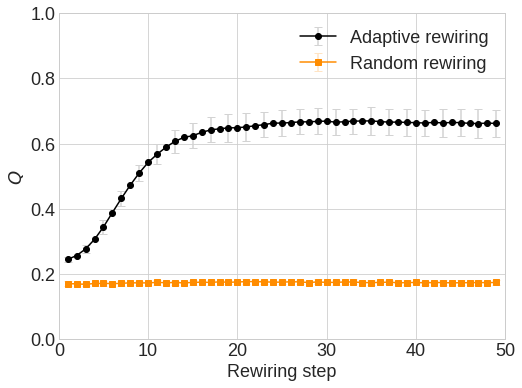

In [108]:
plt.style.use('seaborn-whitegrid')
plt.errorbar(np.arange(1, len(mean)+1), mean, yerr=std, marker="o", ecolor='lightgray', c="k",
            errorevery=2, label="Adaptive rewiring");
plt.errorbar(np.arange(1, len(fake_mean)+1), fake_mean, yerr=fake_std, marker="s", ecolor='bisque', c="darkorange",
            errorevery=2, label="Random rewiring");
plt.ylim([0,1]);
plt.xlim([0,50]);
plt.xlabel("Rewiring step");
plt.ylabel(r"$Q$");
plt.legend()
plt.savefig(os.path.join(DIR, "Modularity_50_runs"))

### Assortativity and rich club coefficent


In [99]:
assortativity_real=np.zeros((dim_1, dim_2))
assortativity_fake=np.zeros((dim_1, dim_2))
for i in tqdm(range(len(Model_List))):
    for j in range(len(Model_List[i].conn_mat_list)):
        assortativity_real[i,j]=nx.algorithms.degree_assortativity_coefficient(nx.from_numpy_array(Model_List[i].conn_mat_list[j]))
        assortativity_fake[i,j]=nx.algorithms.degree_assortativity_coefficient(nx.from_numpy_array(fake_Models[i].conn_mat_list[j]))
    

100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


In [100]:
mean_assort=assortativity_real.mean(axis=0)
std_assort=assortativity_real.std(axis=0)
fake_mean_assort=assortativity_fake.mean(axis=0)
fake_std_assort=assortativity_fake.std(axis=0)

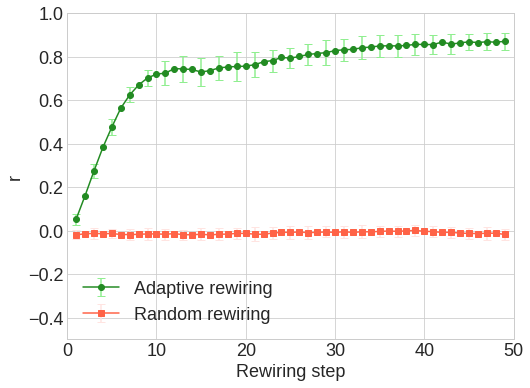

In [109]:
plt.style.use('seaborn-whitegrid')
plt.errorbar(np.arange(1, len(mean)+1), mean_assort, yerr=std_assort, marker="o", ecolor='lightgreen', c="forestgreen",
            errorevery=2, label="Adaptive rewiring");
plt.errorbar(np.arange(1, len(fake_mean)+1), fake_mean_assort, yerr=fake_std_assort, marker="s", ecolor='mistyrose', c="tomato",
            errorevery=2, label="Random rewiring");
plt.ylim([-0.5,1]);
plt.xlim([0,50]);
plt.xlabel("Rewiring step");
plt.ylabel(r"r");
plt.legend()
plt.savefig(os.path.join(DIR, "Assortativity_50_runs"))

### Testing individual models with large N 

In [3]:
MU=4
SIGMA=0.2
N=500
connections=Graphs_random.erdos_renyi_graph(N,0.2)
conn_matrix=nx.to_numpy_matrix(connections)
conn_matrix=np.ascontiguousarray(conn_matrix)
Init_T, Init_F=Kuramoto_model.Generate_initial_distribution(N, MU, SIGMA)
K_crit=50
Model=Kuramoto_model(K_crit, Init_F, Init_T, 0.01, conn_matrix, Uniform_coupling=False)
Model_2=Kuramoto_model(K_crit, Init_F, Init_T, 0.01, conn_matrix, Uniform_coupling=False)
drop_seq=[17, 21, 43]
arg_list=[drop_seq, 0.5]
Model.Hebbian_cycle(1000,50, arg_list, drop_forever=True, fake=False, increment=0.5)
Model_2.Hebbian_cycle(1000,50, drop_forever=False, fake=True, increment=0.5)
Model.Compute_order()
Model_2.Compute_order()

/home/i/ivan-shpurov/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/i/ivan-shpurov/Yeast/Kuramoto_Model/func_Kuramoto/Main_Model.py:50: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  d_theta[i]=Freq[i]+(K/N)*phi@C[:,i]
/apps/free81/python/3.7.3/lib/python3.7/site-packages/numba/core/typing/npydecl.py:952: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/i/ivan-shpurov/Yeast/Kuramoto_Model/func_Kuramoto/Main_Model.py:50: NumbaPerformanceWarning: '@' is faster on cont

In [4]:
modularity, labels=Functions.compute_modularity(Model.conn_mat_list)
labels_after, con_after, cluster_size_after=Functions.label_sort(labels[-1], Model.conn_mat_list[-1])


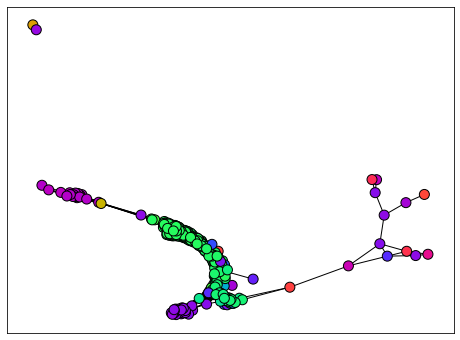

In [5]:
rgb_cycle=Functions.get_rgb()
a=nx.from_numpy_array(Model.conn_mat_list[-1])
color_a=Functions.color_code(Model.final_freq_dist, a, rgb_cycle)
pos = nx.spring_layout(a)
nodes = nx.draw_networkx_nodes(a, pos, node_color=color_a, node_size=100)
nodes.set_edgecolor('k')
nx.draw_networkx_edges(a, pos)
plt.savefig(os.path.join(DIR, "Graph_500_N_Adaptive_1"))

In [151]:
def compute_modulewise(theta_table, labels):
    T=theta_table.shape[1]
    R_partial=np.zeros((T, max(labels)))
    for i in range(T):
        for j in range(min(labels), max(labels)):
            indx=np.where(labels==j)[0]
            theta=np.zeros_like(indx)
            N=theta.shape[0]
            np.take(theta_table[:,i], indx, axis=0, out=theta)
            cos=np.sum(np.cos(theta))
            sin=np.sum(np.sin(theta))
            r_2=(1/N**2)*(cos**2+sin**2)
            R_partial[i,j]=np.sqrt(r_2)
    return R_partial

In [171]:
R_modular=compute_modulewise(Model.theta_table, labels[-1])


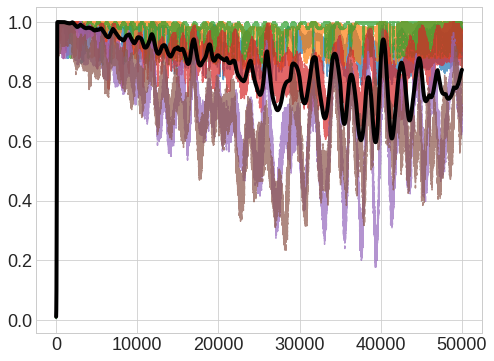

In [172]:
for i in range(R_modular.shape[1]): 
    plt.plot(R_modular[:,i], linestyle="dashed", alpha=0.7)
plt.plot(Model.R, linewidth=4, c="k")

In [10]:
def color_code_2(freq_table, Graph, rgb_cycle): #Returns colorcode for a  graph for a frequency(t)
    connections=Graph
    color_pattern=[]
    a=np.amax(Model.final_freq_dist)
    b=np.amin(Model.final_freq_dist)
    freq_ind=np.linspace(a,b, 100)
    color_ind={freq_ind[i]:rgb_cycle[i] for i in range(freq_ind.shape[0])} #This line maps frequncies to colors in
    arr=np.asarray(list(color_ind.keys()))                        # the rgb cycle
    for node in connections:
        f=freq_table[node]
        j = (np.abs(arr - f)).argmin() #This line selects the closest frequency match
        color=color_ind.get(arr[j])
        color_pattern.append(color)
    return color_pattern

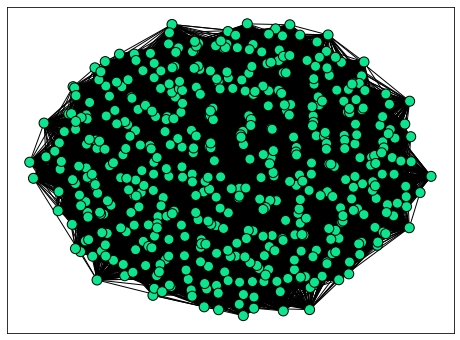

In [11]:
b=nx.from_numpy_array(Model_2.conn_mat_list[-1])
color_b=color_code_2(Model_2.final_freq_dist, b, rgb_cycle)
pos = nx.spring_layout(b)
nodes = nx.draw_networkx_nodes(b, pos, node_color=color_b, node_size=100)
nodes.set_edgecolor('k')
nx.draw_networkx_edges(b, pos)
plt.savefig(os.path.join(DIR, "Graph_500_N_Random_corrected"))

Text(0.5, 1.0, 'Q=0.40036523413912006')

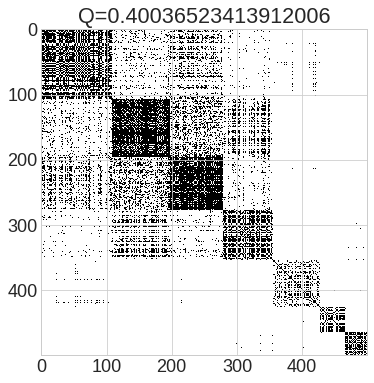

In [162]:
plt.imshow(con_after)
plt.title('Q={}'.format(modularity[-1]))

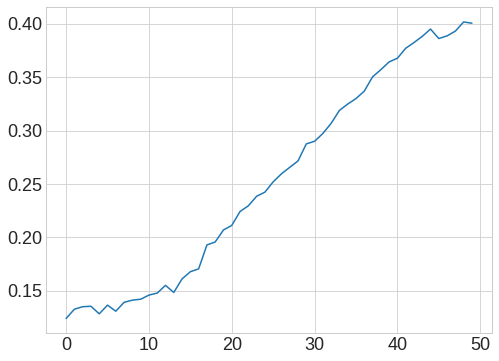

In [163]:
plt.plot(modularity)

In [168]:
degree=Model.conn_mat_list[-1].sum(axis=0)

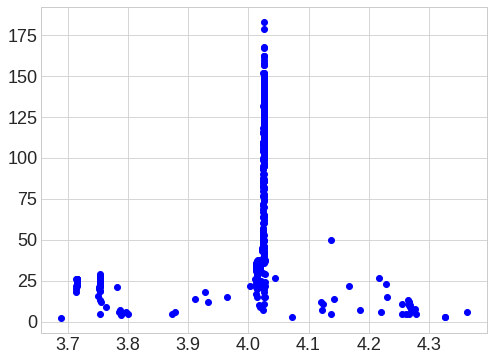

In [169]:
plt.plot(Model.final_freq_dist, degree, "bo")

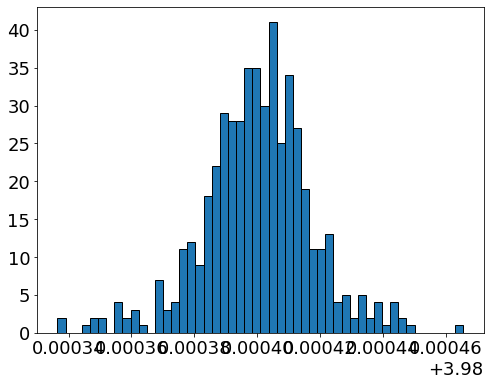

In [7]:
#plt.hist(Model.final_freq_dist, bins=50, edgecolor="k", density=True);
plt.hist(Model_2.final_freq_dist, bins=50, edgecolor="k");

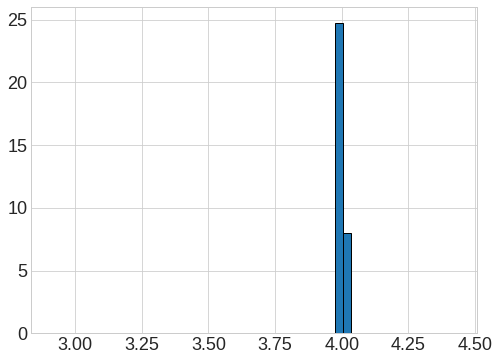

In [183]:
plt.hist(Model.freq_table[-1], bins=50, edgecolor="k", density=True);

In [185]:
Model.final_freq_dist.shape

(500,)

In [191]:
Model.final_freq_dist[:100]

array([4.02548727, 3.7150231 , 4.02518221, 3.78418505, 3.75370228,
       3.71502131, 4.025213  , 4.02591753, 4.02516282, 4.02516487,
       4.02450199, 3.71362514, 4.2704147 , 3.75235174, 4.02518973,
       4.02511721, 3.71513798, 4.02532984, 4.26782581, 4.02515475,
       4.02519014, 4.01437183, 4.02518167, 4.02531729, 4.02512765,
       4.26476242, 4.02562405, 4.0137591 , 4.02518584, 3.71522854,
       4.02607931, 4.01633603, 4.02481246, 4.02517039, 4.0251767 ,
       4.32719135, 4.0251722 , 4.02477721, 4.02505027, 4.02500928,
       4.02518365, 4.02518885, 4.0251328 , 4.18570717, 3.79670268,
       4.01912727, 4.02515321, 4.01687691, 4.27427747, 4.02516813,
       4.02519842, 4.02519018, 4.0236681 , 4.0252015 , 4.02519564,
       4.26767081, 4.02522547, 4.02506634, 4.02518078, 4.01525366,
       4.02515795, 4.02497646, 4.23027582, 4.02525482, 4.12330355,
       3.71519299, 4.02522126, 4.02517007, 4.01860119, 4.02519542,
       4.02519868, 4.02549474, 4.02518309, 4.02522057, 4.27915